In [1]:
import gdown
import os
import pandas as pd
import numpy as np

# from google.colab import files
# uploaded = files.upload()

# sp500_df = pd.read_csv('sp500_dataframe.csv')
# sp500_df.head()

# file share for the companies Dataset: https://drive.google.com/file/d/154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH/view?usp=sharing

file_id_comp = "154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH"
output_file_comp = "sp500_companies.csv"

if not os.path.exists(output_file_comp):
    gdown.download(f"https://drive.google.com/uc?id={file_id_comp}&confirm=t", output_file_comp, quiet=False)

sp500 = pd.read_csv(output_file_comp)
sp500.head()

# file share for the processed Dataset: https://drive.google.com/file/d/1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN/view?usp=sharing

file_id_df = "1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN"
output_file_df = "sp500_dataframe.csv"

if not os.path.exists(output_file_df):
    gdown.download(f"https://drive.google.com/uc?id={file_id_df}&confirm=t", output_file_df, quiet=False)

sp500_df = pd.read_csv(output_file_df)
sp500_df.head()

sp500_tickers = sp500['Symbol'].tolist()
sp500_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Remove numeric index and repalce with the date

sp500_df.set_index("Date", inplace=True)
sp500_df.index.name = None

# Remove tickers row
sp500_df = sp500_df.drop(sp500_df.index[0])
# Remove the date row
sp500_df = sp500_df.drop(sp500_df.index[1])
# Remove the price row
sp500_df = sp500_df.drop(sp500_df.index[2])
sp500_df = sp500_df.drop(sp500_df.index[0])

data = sp500_df.iloc[:, 1:].to_numpy()
n_things = data.shape[1] // 9

reshapedd = data.reshape(data.shape[0], n_things, 9)

final_array = reshapedd.transpose(1, 0, 2)
final_array = np.array(final_array, dtype=np.float64)

final_array = final_array[~np.isnan(final_array).any(axis=(1, 2))]
final_array.shape

Downloading...
From: https://drive.google.com/uc?id=154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH&confirm=t
To: /content/sp500_companies.csv
100%|██████████| 804k/804k [00:00<00:00, 8.92MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN&confirm=t
To: /content/sp500_dataframe.csv
100%|██████████| 28.7M/28.7M [00:00<00:00, 95.8MB/s]
<ipython-input-1-6738dfb4bad0>:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,

(423, 514, 9)

In [2]:
import math
from sklearn.metrics import mean_squared_error

# helper function, basically seperates everything for us
def create_dataset(dataset, time_step):
  dx, dy = [], []
  for i in range(len(dataset)-time_step-1):
      a = dataset[i:(i+time_step), 0]
      dx.append(a)
      dy.append(dataset[i + time_step, 0])
  return np.array(dx), np.array(dy)

# returns a trained model
def trainedModel(dataset, scale, model):
  time_step = 50

  for i in dataset:

    # split data by 70%
    split_size = int(len(i) * 0.70)
    training_set = i[0:split_size, :]
    testing_set = i[split_size: , :1]

    # how much data do we need from the past to get the future (next week)
    X_train, y_train = create_dataset(training_set, time_step)
    X_test, ytest = create_dataset(testing_set, time_step)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    # train model
    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=64,verbose=1)


    # how well ?

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    print(math.sqrt(mean_squared_error(y_train,train_predict)))
    print(math.sqrt(mean_squared_error(ytest,test_predict)))



In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

# preprocessing
time_step = 50
scaler = MinMaxScaler(feature_range=(0, 1))
og_shape = final_array[:20, :, :1].shape
scaled_data = scaler.fit_transform(final_array[:20, :, :1].reshape(-1, 1))
scaled_data = scaled_data.reshape(og_shape)
print(scaled_data.shape)

model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

trainedModel(scaled_data, scaler, model)

(20, 514, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.8549e-04 - val_loss: 0.0012
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.1740e-04 - val_loss: 3.0754e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.7466e-04 - val_loss: 0.0013
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6712e-04 - val_loss: 3.5526e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1353e-04 - val_loss: 2.3192e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.3142e-05 - val_loss: 2.3046e-04
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.8599e-05 - val_loss: 2.3985e-04
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 6.6077e-05 - val_loss: 5.5119e-04
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6.7210e-05 - val_loss: 3.5275e-04
Epoch 12/30
5/5 ━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(514, 1)
(514, 1)


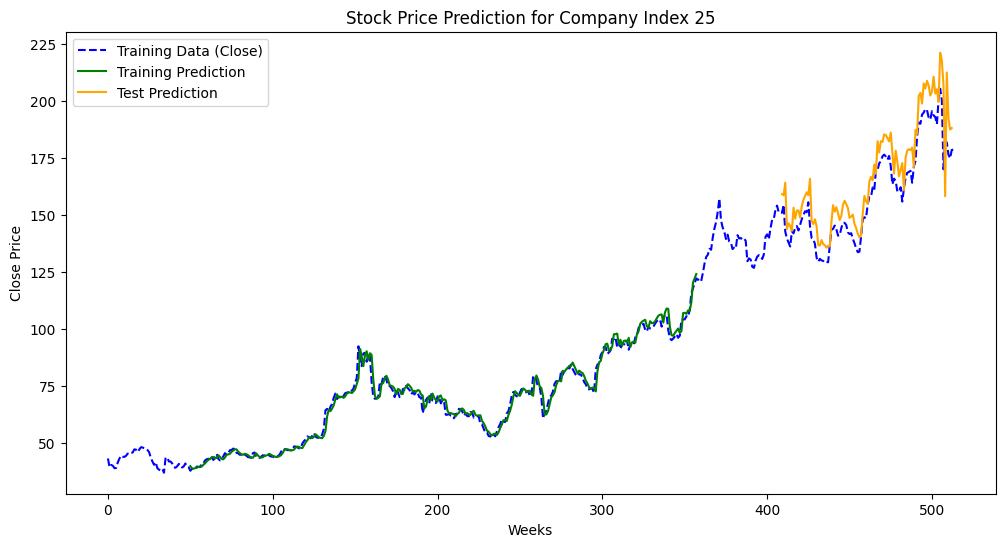

In [4]:
import matplotlib.pyplot as plt


look_back = time_step

df1 = scaler.fit_transform(final_array[25, :, :1].reshape(-1, 1))
split_size = int(len(df1) * 0.70)
training_set = df1[0:split_size, :]
testing_set = df1[split_size: , :1]

# how much data do we need from the past to get the future (next week)
X_train, y_train = create_dataset(training_set, look_back)
X_test, ytest = create_dataset(testing_set, look_back)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
print(testPredictPlot.shape)

# plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.title(f"Stock Price Prediction for Company Index 25")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.plot(scaler.inverse_transform(df1), label="Training Data (Close)",  linestyle="--", color="blue")
plt.plot(trainPredictPlot, label="Training Prediction", color="green")
plt.plot(testPredictPlot, label="Test Prediction", color="orange")
plt.legend()
plt.show()

In [5]:
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(GRU(50))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

trainedModel(scaled_data, scaler, model_gru)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0013 - val_loss: 0.0100
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.9896e-04 - val_loss: 0.0032
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.5716e-04 - val_loss: 5.1609e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.2028e-04 - val_loss: 8.3155e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.7980e-04 - val_loss: 8.7119e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3992e-04 - val_loss: 1.7728e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.0053e-04 - val_loss: 3.7723e-04
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.3328e-05 - val_loss: 1.5469e-04
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.9186e-05 - val_loss: 1.1354e-04
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.5918e-05 - val_loss: 1.1510e-04
Epoch 12/30
5/5 ━━━━━━━━━━━

(308, 50, 1)
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(514, 1)
(514, 1)


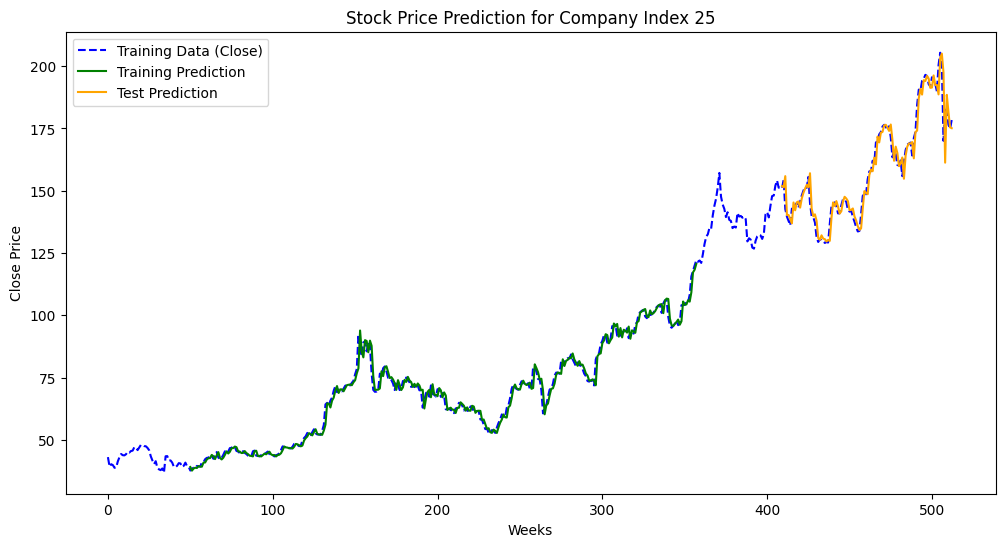

In [10]:
import matplotlib.pyplot as plt


look_back = time_step

df1 = scaler.fit_transform(final_array[25, :, :1].reshape(-1, 1))
split_size = int(len(df1) * 0.70)
training_set = df1[0:split_size, :]
testing_set = df1[split_size: , :1]

# how much data do we need from the past to get the future (next week)
X_train, y_train = create_dataset(training_set, look_back)
X_test, ytest = create_dataset(testing_set, look_back)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
train_predict = model_gru.predict(X_train)
test_predict = model_gru.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
print(testPredictPlot.shape)

# plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.title(f"Stock Price Prediction for Company Index 25")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.plot(scaler.inverse_transform(df1), label="Training Data (Close)",  linestyle="--", color="blue")
plt.plot(trainPredictPlot, label="Training Prediction", color="green")
plt.plot(testPredictPlot, label="Test Prediction", color="orange")
plt.legend()
plt.show()

(12,)
(52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.96765375]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.96079254]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.95473605]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.9496775]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.94535077]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.94147265]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.9378695]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.934461]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.93121636]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.92812395]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.9251771]]
(1, 52, 1)
(1, 52, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.92236906]]
(1, 52, 1)
[[47.39242 ]
 [47.24264 ]
 [47.110435]
 [47.000008]
 [46.905552]
 [46.820892]
 [46.742237]


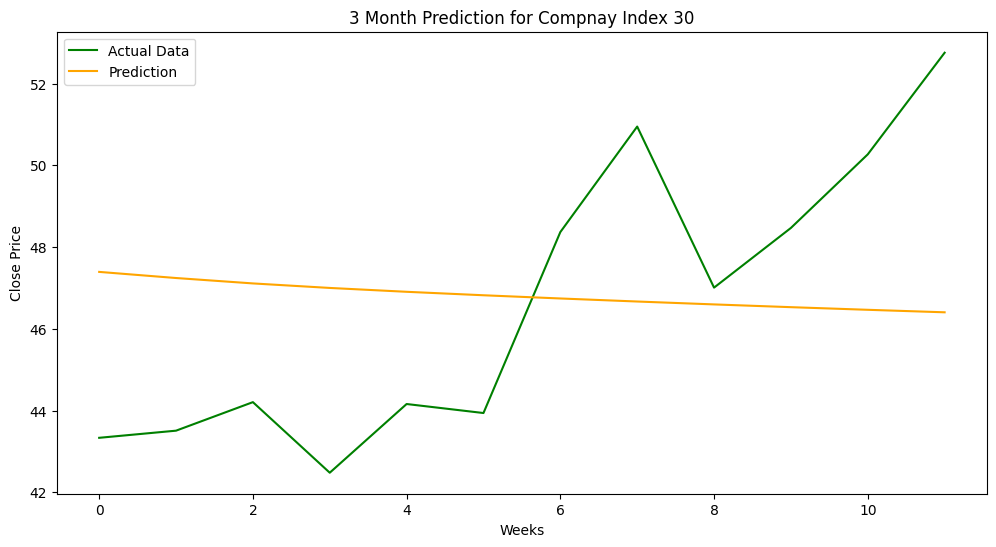

In [78]:
# predicting one month
weeks = 12
predicted_weeks = []

df1 = scaler.fit_transform(final_array[30, 300:352, :1].reshape(-1, 1))
actual_data = final_array[30, 352: 352 + weeks, 1]
print(actual_data.shape)
print(df1.shape)

df1 = df1.reshape(1, 52, 1)

for i in range(weeks):
  print(df1.shape)
  train_predict = model_gru.predict(df1)
  print(train_predict)
  predicted_weeks.append(train_predict)
  df1 = df1[:, 1:, :]
  df1 = np.append(df1, np.array([train_predict]), axis=1)
  print(df1.shape)

predicted_weeks = np.array(predicted_weeks)
predicted_weeks = scaler.inverse_transform(predicted_weeks.reshape(-1, 1))

print(predicted_weeks)
print(actual_data)

plt.figure(figsize=(12, 6))
plt.title(f"3 Month Prediction for Compnay Index 30")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.plot(actual_data, label="Actual Data", color="green")
plt.plot(predicted_weeks, label="Prediction", color="orange")
plt.legend()
plt.show()